# ArcGIS API for Python を用いたデータの集計・可視化

* このノートブックは 2019/08/23 開催の**「ArcGIS 開発者のための最新アプリ開発塾 2019」**での **ArcGIS プラットフォームを活用した調査アプリケーション構築までのハンズオン** における ArcGIS API for Python を用いたデータの集計及び解析を実行するノートブックです。
* 当該ハンズオン内で Runtime SDK for .NET を用いたアプリを構築する際に作成した ArcGIS Online 上のフィーチャ サービスを用いることを想定しています。
* 利用しているデータは全てハンズオン目的のために作成した架空のデータです。
* 次のセルの目次の **参考①、②、③はハンズオン終了後、お時間のある時にチャレンジ** してみてください。
* 各章の冒頭でその中で使用するモジュール、クラス、メソッドの API リファレンスへのリンクを貼っています。

## 目次

1. Jupyter Notebookの操作方法 (最低限)
1. ArcGIS API for Python のアーキテクチャの確認
1. gis モジュールを使ったポータルへのログインとデータへのアクセス
    * ポータルへのアクセス
    * ポータル内のデータへのアクセス
1. features モジュールを使ったデータの解析
    * Spatially Enabled DataFrame の作成
    * Jupyter Notebook 上でのマップによる可視化
1. 参考①: DataFrame への列の追加とパイ チャートの作成
1. 参考②: アイテムを複製して、データをバックアップする方法
1. 参考③: ArcGIS Online の解析サービスを利用したホットスポット分析
    * 参考③は ArcGIS Pro で環境構築した場合のみを想定したサンプルです

---

## 1.Jupyter Notebookの操作方法（最低限）

* セル入力：セルを指定してEnter
* セルの実行：Shift + Enter
* コメントアウト：Ctrl + /
* docstring の表示：Shift + Tab

In [1]:
# Hello world を試しましょう

# print("Hello World!")

Hello World!


参考: 画面上部のプルダウンを *code* から *Markdown* に変更すると Markdown で文章等を書くこともできます。
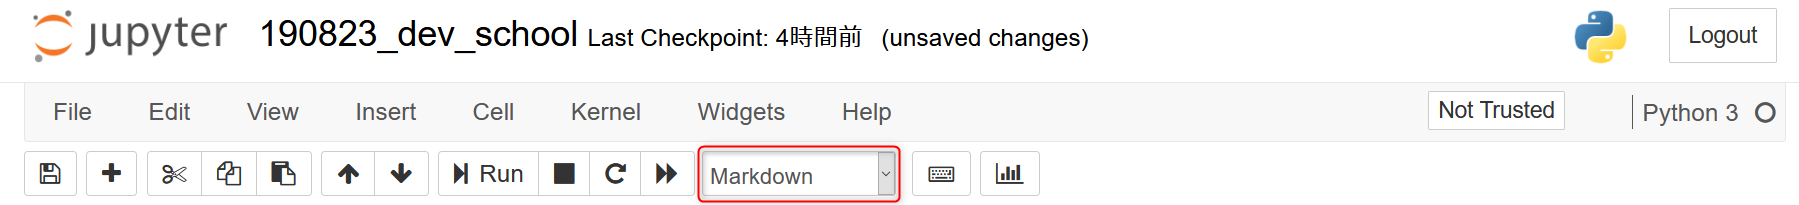

---

## 2.ArcGIS API for Python のアーキテクチャの確認
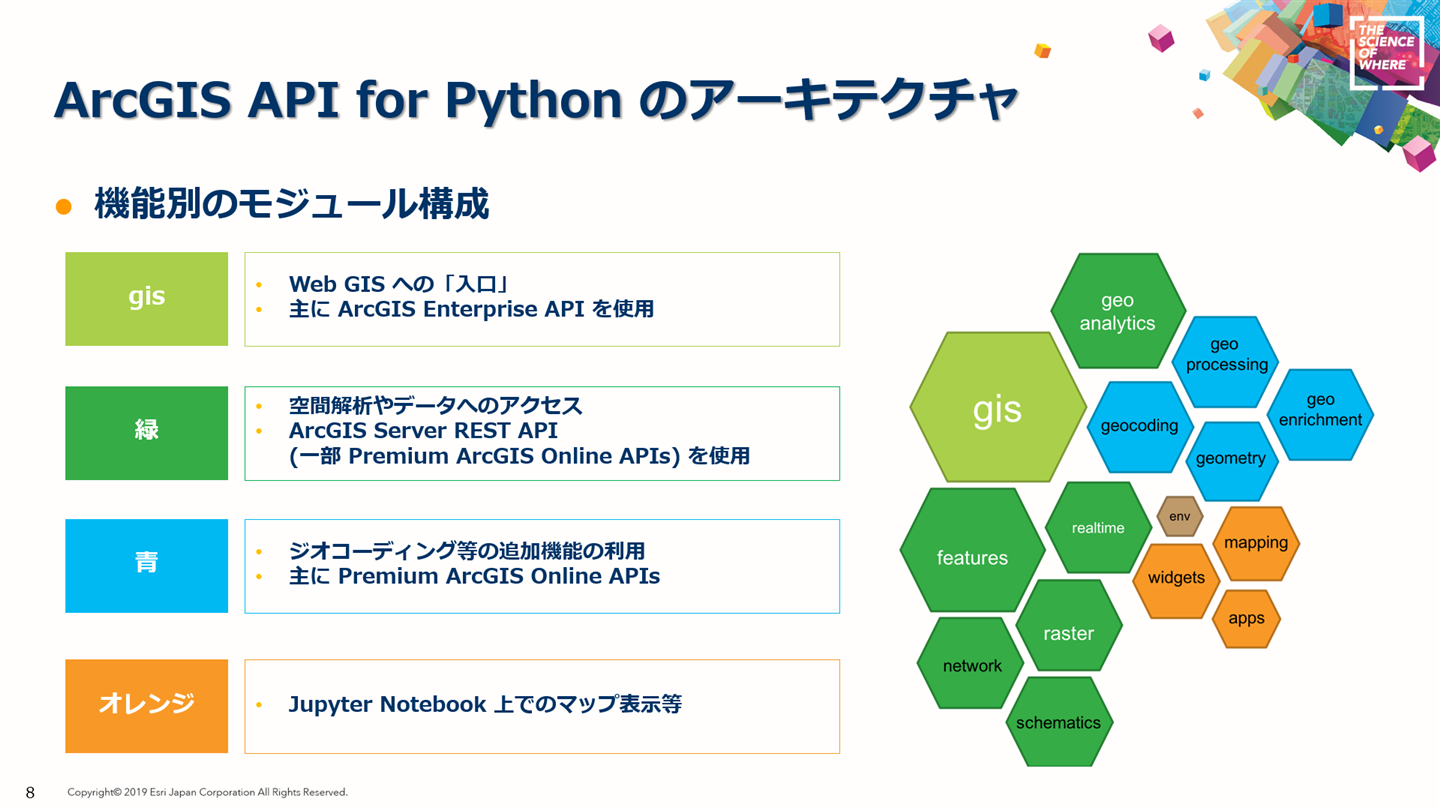

---

## 3. gis モジュールを使ったポータルへのログインとデータへのアクセス

### ポータルへのアクセス
* gis モジュール：[arcgis.gis](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#gis)
    * GIS クラス：[arcgis.gis.GIS](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.GIS)

In [1]:
# gis モジュールのインポート

from arcgis.gis import *

# GIS でポータルにログイン
# URL をご自身の組織サイトの URL とユーザーネームに変更してください
# URL がわからない人は https://www.arcgis.comでもログイン可能です
# 実行するとパスワードの入力を求められるので、プロンプトに入力して Enter
# (セキュリティのため、スクリプト内にパスワードを記載することはお勧めしません)

gis = GIS("https://<開発者アカウントのユーザー名>.maps.arcgis.com", username = "ユーザー名")

Enter password: ········


### ポータル内のデータへのアクセス
* ContentManager クラス：[arcgis.gis.ContentManager](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#contentmanager)
    * search() メソッド：[arcgis.gis.ContentManager.search()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html?#arcgis.gis.ContentManager.search)

<Item title:"tree_inspection_gdb" type:File Geodatabase owner:nakamura_dev_org>
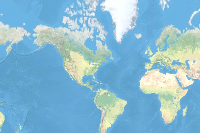

<Item title:"tree_inspection_gdb" type:Feature Layer Collection owner:nakamura_dev_org>
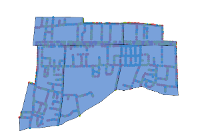

In [2]:
# ContentManager クラス の search() メソッドでポータル内のアイテムを検索
# ContentManager はヘルパークラスです。gis.content で利用することができます。

for item_i in gis.content.search("tree_inspection_gdb"):
    display(item_i)

<Item title:"tree_inspection_gdb" type:Feature Layer Collection owner:nakamura_dev_org>
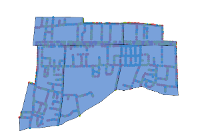

In [17]:
# 解析に使うフィーチャ サービス を target_lyr_collection に代入しましょう。
# item_type パラメータ－を指定することでアイテムのタイプで絞り込みができます。
# ※ search() メソッドの結果はリストで返却されます

target_lyr_collection = gis.content.search("tree_inspection_gdb", item_type = "Feature Service")[0]
target_lyr_collection

---

## 4. features モジュールを使ったデータの集計・可視化

### Spatially Enabled DataFrame の作成
* features モジュール：[arcgis.features](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#module-arcgis.features)
    * GeoAccessor クラス：[arcgis.features.GeoAccessor](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#geoaccessor)
        * from_layer メソッド：[arcgis.features.GeoAccessor.from_layer()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_layer)

グラフの描画には [matplotlib](https://matplotlib.org/#) を利用しています。

Spatially Enabled DataFrame は Pandas DataFrame を拡張して地理空間情報を扱えるようにしたものです。データの集計や可視化等でよく利用される Pandas ベースのメソッド等を活用できます。

In [18]:
# 必要なモジュール等をインポートします
from arcgis.features import *   # features モジュール
import matplotlib.pyplot as plt # matplotlib
import pandas as pd             # pandas

# layers でフィーチャ レイヤーの各レイヤーにアクセス
# 今回は樹木のレイヤーのみ抽出
target_lyr = target_lyr_collection.layers[1]

# Spatially Enabled DataFrame へ変換
sedf = GeoAccessor.from_layer(target_lyr)

In [19]:
sedf.head()

OBJECTID Planted_By                              GlobalID  Site_Width  \
0         1             9014766a-df76-4515-b4d8-104095d70b92         7.5   
1         2             e8306055-5d92-4b34-9975-f98519bab9e2         7.5   
2         5             1eedc155-2700-4069-b2a1-4f14b1aaec85         0.0   
3         6             a9550867-3a8a-4b7d-bcb2-6a0adfc7b785         0.0   
4         7             c4bbc397-4041-4a3f-8df6-37224acd8b38         0.0   

  Planted_Date                      Species_GlobalID Condition   DBH  \
0   1994-11-15  7fb04a2c-73a5-47b1-b8e5-1a9b96947eff         3  15.3   
1   1994-11-15  82a76986-4e76-49d0-aeda-607c4674cb9a         2  13.4   
2   2003-06-11  22d0334e-a1e9-404a-b4fd-e759d10b937c         2   6.1   
3   2003-06-11  22d0334e-a1e9-404a-b4fd-e759d10b937c         1   6.8   
4   2003-06-11  9be86d9a-2e1a-4489-8e55-7e3d268ca58f         2   7.5   

  Neighborhood           Address        CreationDate           Creator  \
0          B地区  東京都小金井市緑町３-１０-２０ 2019-08-21 14:10:56  nakamura_dev_org   
1          B地区  東京都小金井市緑町３-１０-２１ 2019-08-21 14:10:56  nakamura_dev_org   
2          C地区   東京都小金井市緑町３-４-１９ 2019-08-21 14:10:56  nakamura_dev_org   
3          C地区   東京都小金井市緑町３-１０-８ 2019-08-21 14:10:56  nakamura_dev_org   
4          C地区   東京都小金井市緑町３-１０-８ 2019-08-21 14:10:56  nakamura_dev_org   

             EditDate            Editor  \
0 2019-08-21 14:10:56  nakamura_dev_org   
1 2019-08-21 14:10:56  nakamura_dev_org   
2 2019-08-21 14:10:56  nakamura_dev_org   
3 2019-08-21 14:10:56  nakamura_dev_org   
4 2019-08-21 14:10:56  nakamura_dev_org   

                                               SHAPE  
0  {"x": 15530528.638499998, "y": 4260927.9422999...  
1  {"x": 15530530.322899995, "y": 4260940.9702000...  
2  {"x": 15530732.720399998, "y": 4260776.6668, "...  
3  {"x": 15530743.3653, "y": 4260776.729000002, "...  
4  {"x": 15530754.634800002, "y": 4260776.3870000...

<BarContainer object of 4 artists>

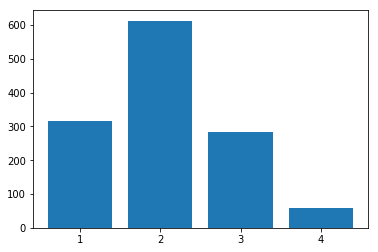

In [20]:
# groupby() で Condition (樹木の状態) 別にグルーピング。count() で行数をカウント。
aggregate_condition = sedf.groupby("Condition", as_index=False).count()

# 各 Condition 毎の行数をバープロットで可視化
plt.bar(x = aggregate_condition["Condition"], height = aggregate_condition["OBJECTID"])

### Jupyter Notebook 上でのマップによる可視化
* gis モジュール：[arcgis.gis](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#gis)
    * GIS クラス：[arcgis.gis.GIS](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.GIS)
        * map() メソッド：[arcgis.gis.GIS.map()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.GIS.map)
* features モジュール：[arcgis.features](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#module-arcgis.features)
    * GeoAccessor クラス：[arcgis.features.GeoAccessor](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#geoaccessor)
        * plot() メソッド：[arcgis.features.GeoAccessor.plot()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.GeoAccessor.plot)

In [21]:
# 不調もしくは枯死した樹木 (Condition が 3 以上の樹木) のみを抽出し、新たな Spatially Enabled DataFrame 作成する
sedf_bad_conditions = sedf.query("Condition == '3' | Condition == '4'") # pandas の query() メソッド
sedf_bad_conditions.head()

OBJECTID Planted_By                              GlobalID  Site_Width  \
0          1             9014766a-df76-4515-b4d8-104095d70b92         7.5   
8         12             cb4f7e12-4aa5-491f-bd30-04be4deb3664         0.0   
30        36             258d0b03-5779-4a36-a739-2d60e18b738e         5.5   
39        51             209e6832-4cbe-4777-ab66-bb19542d2544         7.5   
40        52             e6787101-8ab8-4cf1-b795-5a2bc1ad0c9e         7.5   

   Planted_Date                      Species_GlobalID Condition   DBH  \
0    1994-11-15  7fb04a2c-73a5-47b1-b8e5-1a9b96947eff         3  15.3   
8    2001-01-20  440c7a0e-bdf0-4fd6-bd72-e57df8b8c006         3  25.5   
30   1994-11-15  7fb04a2c-73a5-47b1-b8e5-1a9b96947eff         3  11.3   
39   1997-10-01  22d0334e-a1e9-404a-b4fd-e759d10b937c         4  10.8   
40   1997-10-01  440c7a0e-bdf0-4fd6-bd72-e57df8b8c006         3  36.0   

   Neighborhood           Address        CreationDate           Creator  \
0           B地区  東京都小金井市緑町３-１０-２０ 2019-08-21 14:10:56  nakamura_dev_org   
8           D地区  東京都小金井市緑町２-１６-２２ 2019-08-21 14:10:56  nakamura_dev_org   
30          B地区  東京都小金井市緑町２-１４-３５ 2019-08-21 14:10:56  nakamura_dev_org   
39          C地区   東京都小金井市緑町３-５-１３ 2019-08-21 14:10:56  nakamura_dev_org   
40          C地区  東京都小金井市関野町２-５-１４ 2019-08-21 14:10:56  nakamura_dev_org   

              EditDate            Editor  \
0  2019-08-21 14:10:56  nakamura_dev_org   
8  2019-08-21 14:10:56  nakamura_dev_org   
30 2019-08-21 14:10:56  nakamura_dev_org   
39 2019-08-21 14:10:56  nakamura_dev_org   
40 2019-08-21 14:10:56  nakamura_dev_org   

                                                SHAPE  
0   {"x": 15530528.638499998, "y": 4260927.9422999...  
8   {"x": 15531391.978, "y": 4260807.947999999, "s...  
30  {"x": 15530562.8676, "y": 4260860.384800002, "...  
39  {"x": 15530970.3341, "y": 4260935.941399999, "...  
40  {"x": 15530969.8758, "y": 4260951.5200999975, ...

In [22]:
map1 = gis.map("東京都小金井市")
map1

MapView(layout=Layout(height='400px', width='100%'))

In [23]:
# plot メソッドでマップ上に可視化

sedf_bad_conditions.spatial.plot(
    map_widget = map1,   # プロットするマップ
    renderer_type = "u", # 個別値 (unique value) でレンダリング
    col = "Condition",   # レンダリングに使用する列の指定
    cmap = "RdBu",       # カラーマップを指定
    line_width = 0.5,    # シンボルのラインの太さ
    alpha = 0.7          # 透過率
)
map1.legend = True      # 凡例の表示

In [24]:
map2 = gis.map("東京都小金井市")
map2

MapView(layout=Layout(height='400px', width='100%'))

In [25]:
# ヒートマップ表示

sedf_bad_conditions.spatial.plot(
    map_widget = map2,
    renderer_type = "h", # ヒートマップでレンダリング
)

True

---

## 5. 参考①: DataFrame への列の追加とパイ チャートの作成
### DataFrame への列の追加とパイ チャートの作成
グラフの描画には [matplotlib](https://matplotlib.org/#) を利用しています。

In [28]:
# gis モジュールのインポート

from arcgis.gis import *        # gis モジュール
from arcgis.features import *   # features モジュール
import matplotlib.pyplot as plt # matplotlib
import pandas as pd             # pandas

# GIS でポータルにログイン
# URL をご自身の組織サイトの URL とユーザーネームに変更してください
# URL がわからない人は https://www.arcgis.comでもログイン可能です
# 実行するとパスワードの入力を求められるので、プロンプトに入力して Enter
# (セキュリティのため、スクリプト内にパスワードを記載することはお勧めしません)

gis = GIS("https://<開発者アカウントのユーザー名>.maps.arcgis.com", username = "ユーザー名")

Enter password: ········


<Item title:"tree_inspection_gdb" type:Feature Layer Collection owner:nakamura_dev_org>
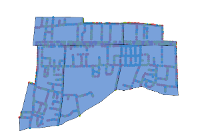

In [29]:
target_lyr_collection = gis.content.search("tree_inspection_gdb", item_type = "Feature Service")[0]
target_lyr_collection

In [35]:
# layers でフィーチャ レイヤーの各レイヤーにアクセス
target_lyr = target_lyr_collection.layers[1]

# Spatially Enabled DataFrame へ変換
sedf = GeoAccessor.from_layer(target_lyr)

In [36]:
# 枯死した樹木 (Condition が 4 の樹木) のみを抽出する
sedf = sedf.query("Condition == '4'") # pandas の query() メソッド
sedf.head()

OBJECTID Planted_By                              GlobalID  Site_Width  \
39         51             209e6832-4cbe-4777-ab66-bb19542d2544         7.5   
83         95             11080ff4-5012-46e1-998f-f47823dc3741         8.6   
100       112             e4c55c8a-f755-462c-ab68-2741ccd0accd         6.7   
101       113             19c63bf1-e43a-48ca-a860-8f077ca787e9         6.7   
102       114             37d2f809-5bf3-4191-b71c-4c3cfb58adc2         6.7   

    Planted_Date                      Species_GlobalID Condition   DBH  \
39    1997-10-01  22d0334e-a1e9-404a-b4fd-e759d10b937c         4  10.8   
83    1974-08-02  9be86d9a-2e1a-4489-8e55-7e3d268ca58f         4   1.8   
100   1971-08-02  9be86d9a-2e1a-4489-8e55-7e3d268ca58f         4  10.1   
101   1971-08-02  9be86d9a-2e1a-4489-8e55-7e3d268ca58f         4   7.9   
102   1971-08-02  9be86d9a-2e1a-4489-8e55-7e3d268ca58f         4   9.0   

    Neighborhood           Address        CreationDate           Creator  \
39           C地区   東京都小金井市緑町３-５-１３ 2019-08-21 14:10:56  nakamura_dev_org   
83           A地区   東京都小金井市緑町３-１４-８ 2019-08-21 14:10:56  nakamura_dev_org   
100          A地区  東京都小金井市緑町３-１２-１５ 2019-08-21 14:10:56  nakamura_dev_org   
101          A地区  東京都小金井市緑町３-１２-４３ 2019-08-21 14:10:56  nakamura_dev_org   
102          A地区   東京都小金井市関野町１-７-１ 2019-08-21 14:10:56  nakamura_dev_org   

               EditDate            Editor  \
39  2019-08-21 14:10:56  nakamura_dev_org   
83  2019-08-21 14:10:56  nakamura_dev_org   
100 2019-08-21 14:10:56  nakamura_dev_org   
101 2019-08-21 14:10:56  nakamura_dev_org   
102 2019-08-21 14:10:56  nakamura_dev_org   

                                                 SHAPE  
39   {"x": 15530970.3341, "y": 4260935.941399999, "...  
83   {"x": 15530537.7232, "y": 4261159.089299999, "...  
100  {"x": 15530896.934199996, "y": 4261156.6884, "...  
101  {"x": 15530887.783299996, "y": 4261157.5622000...  
102  {"x": 15530876.386299998, "y": 4261157.2252999...

* 枯死した樹木の伐採にどれだけの費用がかかるかを、大阪府枚方市の平成28年度樹木管理委託単価表をもとに試算します
* ここでは簡単のために枯死した樹木の全てが幹周りが60cm以上90cm未満として試算
    * 支障木伐採工 人力伐採（処分共） 幹周60cm以上90cm未満：**36,153円**
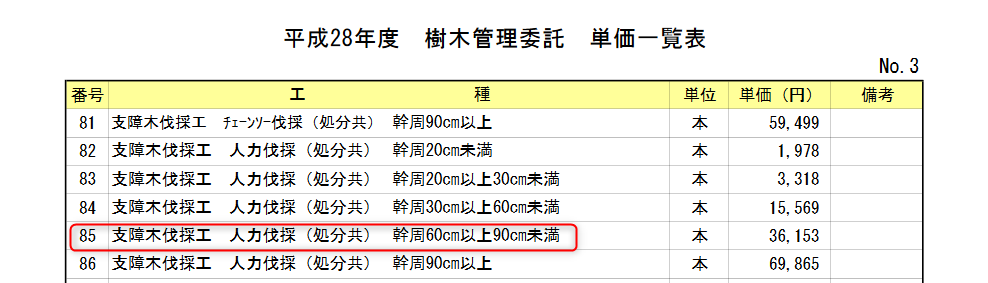
https://www.city.hirakata.osaka.jp/cmsfiles/contents/0000008/8181/83026.pdf

In [37]:
# 枯死した樹木の伐採費用の算出

unit_price = 36153
"{:,}".format(unit_price * len(sedf)) + "円"

'2,169,180円'

<BarContainer object of 10 artists>

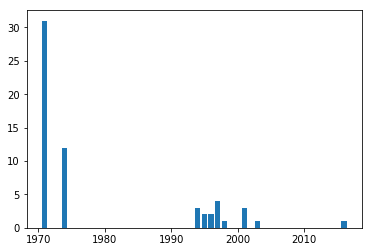

In [38]:
# 枯死している樹木がいつごろ植栽されたかを確認
# 枯死している樹木が植栽された年をコピーし年だけを抽出したものを新たな列 (Planted_Date_Year) として追加
sedf.loc[:, "Planted_Date_Year"] = sedf.loc[:, "Planted_Date"].copy().dt.year

# groupby() で新しく作成した Planted_Date_Year 列の値毎にグルーピング。count() で行数をカウント。
sedf = sedf.groupby("Planted_Date_Year", as_index = False).count()

# 各年の行数をバープロットで可視化
plt.bar(sedf["Planted_Date_Year"], sedf["OBJECTID"])

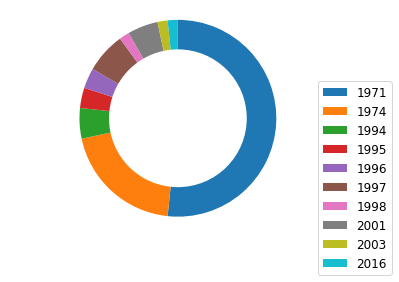

In [39]:
# パイ チャートを作成し、割合を把握
# ラベル付けのために年を文字列に変換し label に格納
label = sedf["Planted_Date_Year"].astype(str)

# パイチャートを作成
plt.pie(sedf["OBJECTID"], counterclock=False, startangle=90)
plt.axis('equal')
# 凡例を作成
plt.legend(label, fontsize=12, bbox_to_anchor=(0.9, 0.7))

# 中心(0,0)に70%の大きさで白い円を描画し、ドーナツ チャートに仕上げる
centre_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

* 1970年代初頭に植栽した樹木が枯死していることがわかります

---

## 6. 参考②: アイテムをエクスポートして、データをバックアップする方法
* gis モジュール：[arcgis.gis](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#gis)
    * Item クラス：[arcgis.gis.Item](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#item)
        * export() メソッド：[arcgis.gis.Item.clone_items()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.Item)
        * publish() メソッド：[arcgis.gis.Item.publish()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.Item.publish)

調査後にフィーチャ サービスをファイル ジオデータベース等にエクスポートすることで、その日の状態をスナップショットとして保存しておくことが可能です。

In [42]:
# gis モジュールのインポート

from arcgis.gis import *

# GIS でポータルにログイン
# URL をご自身の組織サイトの URL とユーザーネームに変更してください
# URL がわからない人は https://www.arcgis.comでもログイン可能です
# 実行するとパスワードの入力を求められるので、プロンプトに入力して Enter
# (セキュリティのため、スクリプト内にパスワードを記載することはお勧めしません)

gis = GIS("https://<開発者アカウントのユーザー名>.maps.arcgis.com", username = "ユーザー名")

Enter password: ········


<Item title:"tree_inspection_gdb" type:Feature Layer Collection owner:nakamura_dev_org>
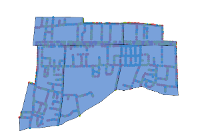

In [43]:
target_lyr_collection = gis.content.search("tree_inspection_gdb", item_type = "Feature Service")[0]
target_lyr_collection

In [44]:
# 今日の日付を文字列で取得 (いつの時点のデータか識別するために使用)
import datetime
today = datetime.date.today()
today_str = today.strftime("%y%m%d")
today_str

'190821'

In [45]:
# Item クラスの export() メソッドを用いることでフィーチャ サービスをファイル形式でエクスポートすることが可能です。
# 少し時間がかかります。
exported_fgdb = target_lyr_collection.export(
    title = target_lyr_collection.title + "_" + today_str, # アイテムのタイトル
    export_format = "File Geodatabase"                     # 出力するフォーマット (今回はファイル ジオデータベース)
)
exported_fgdb

<Item title:"tree_inspection_gdb_190821" type:File Geodatabase owner:nakamura_dev_org>

In [46]:
# エクスポートされたアイテムはポータルからダウンロード可能です。
# publish() メソッドを用いることでサービスとして公開することもできます。

exported_fgdb.publish()

<Item title:"tree_inspection_gdb_190821" type:Feature Layer Collection owner:nakamura_dev_org>

参考：以下のブログ記事ではエクスポートしたファイル ジオデータベースをダウンロードし、ArcGIS Pro も用いてレポートを作成する手順を解説しています。

[GISコミュニティフォーラム開催報告：Web GIS で集めたデータをArcGIS Pro でも活用しよう！～レポート作成までのステップ～](https://community.esri.com/docs/DOC-13488)

---

## 7. 参考③: ArcGIS Online の解析サービスを利用したホットスポット分析
* features.analysis モジュール：[arcgis.features.analysis](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.analysis.html#arcgis-features-analysis-module)
    * find_hot_spots メソッド：[arcgis.features.analysis.find_hot_spots()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.analysis.html#find-hot-spots)

ArcGIS Onlineの解析ツールを実行して、状態の悪い樹木や枯死した樹木が、他の地域より統計的に有意に多い場所を見つけます。

**本サンプルコードは ArcGIS Pro で環境構築した場合のみを想定したサンプルコードです。**

In [57]:
# gis モジュールのインポート

from arcgis.gis import *

# GIS でポータルにログイン
# URL をご自身の組織サイトの URL とユーザーネームに変更してください
# URL がわからない人は https://www.arcgis.comでもログイン可能です
# 実行するとパスワードの入力を求められるので、プロンプトに入力して Enter
# (セキュリティのため、スクリプト内にパスワードを記載することはお勧めしません)

gis = GIS("https://<開発者アカウントのユーザー名>.maps.arcgis.com", username = "ユーザー名")

Enter password: ········


<Item title:"tree_inspection_gdb" type:Feature Layer Collection owner:nakamura_dev_org>
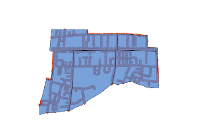

In [58]:
target_lyr_collection = gis.content.search("tree_inspection_gdb", item_type = "Feature Service")[0]
target_lyr_collection

In [59]:
# 状態の悪い樹木、枯死した樹木のみを抽出

target_lyr = target_lyr_collection.layers[1]
sedf = GeoAccessor.from_layer(target_lyr)
sedf_bad_conditions = sedf.query("Condition == '3' | Condition == '4'")

In [60]:
bad_conditions_fservice = sedf_bad_conditions.spatial.to_featurelayer(title = "bad_conditions_fservice", tags = ["test"])

In [61]:
# ホットスポット分析
# 使用するクレジットを estimate オプションで推計可能

arcgis.features.analysis.find_hot_spots(
    analysis_layer = bad_conditions_fservice, # 解析の対象となるレイヤーを指定
    shape_type = "Hexagon",                   # 集計に用いるポリゴンの形状を指定。今回は六角形を使用 (v1.6.1 から使用可)。
    estimate = True                          # True にすると解析に必要なクレジット数を推計できる
)

0.345

* Essential プランでもサービス クレジットが毎月 50 クレジット無償で提供されます。
* Builder 以上の有償プランであれば年間 2500 クレジット利用できる ArcGIS Online の組織向けプラン (開発及びテスト用途限定) が付帯します。
* サーバーを立てずにすぐに開発を始められるところが ArcGIS Online を利用する大きなメリットです。クレジットを賢く使ってスマートに開発を進めてください。

参考：[ArcGIS Online のサービス クレジットを賢く使う 4 つのコツ](https://blog.esrij.com/2018/12/11/post-32034/)
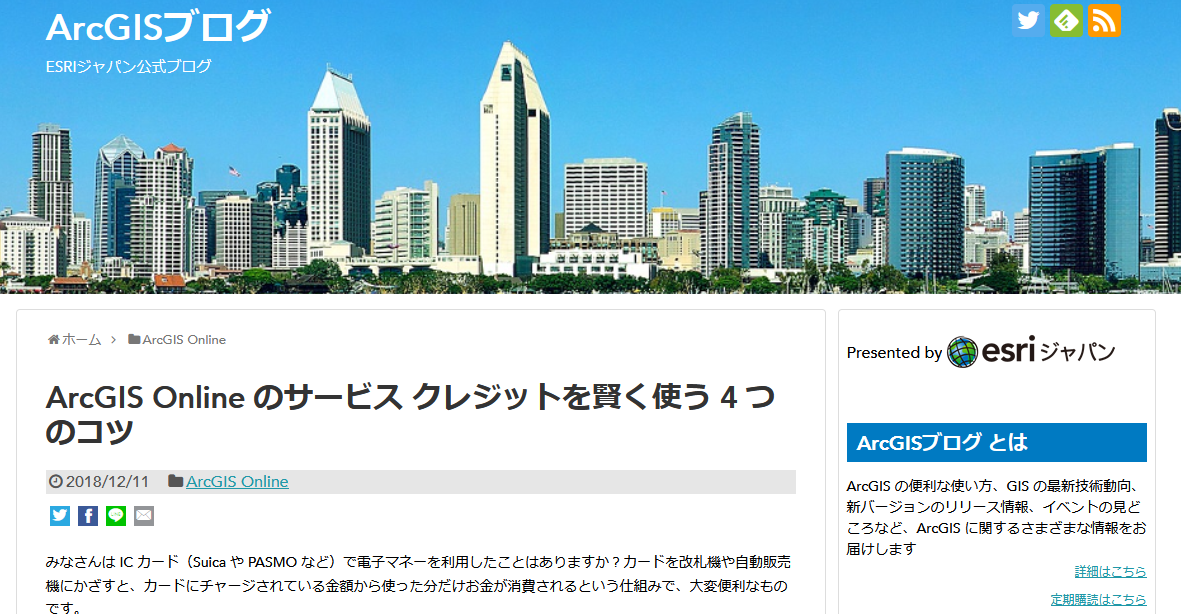

In [62]:
# クレジット使用量を確認後、ホットスポット分析を実行
# 少し時間がかかります

hotspot_result = arcgis.features.analysis.find_hot_spots(
    analysis_layer = bad_conditions_fservice,
    shape_type = "Hexagon",
    output_name = "hotspot_bad_condition_lyr" # 結果をフィーチャ サービスとして保存する際のアイテム名
)
hotspot_result

<Item title:"hotspot_bad_condition_lyr" type:Feature Layer Collection owner:nakamura_dev_org>

* 作成されたフィーチャ サービスを確認すると以下の画像のような結果になるかと思います
* 赤い部分は統計的に優位にポイントの数が多い (この場合、不調～枯死している樹木が多い) 地点です
* ArcGIS Online の解析機能では、このような空間統計的な解析も数行のコードだけで実行できます
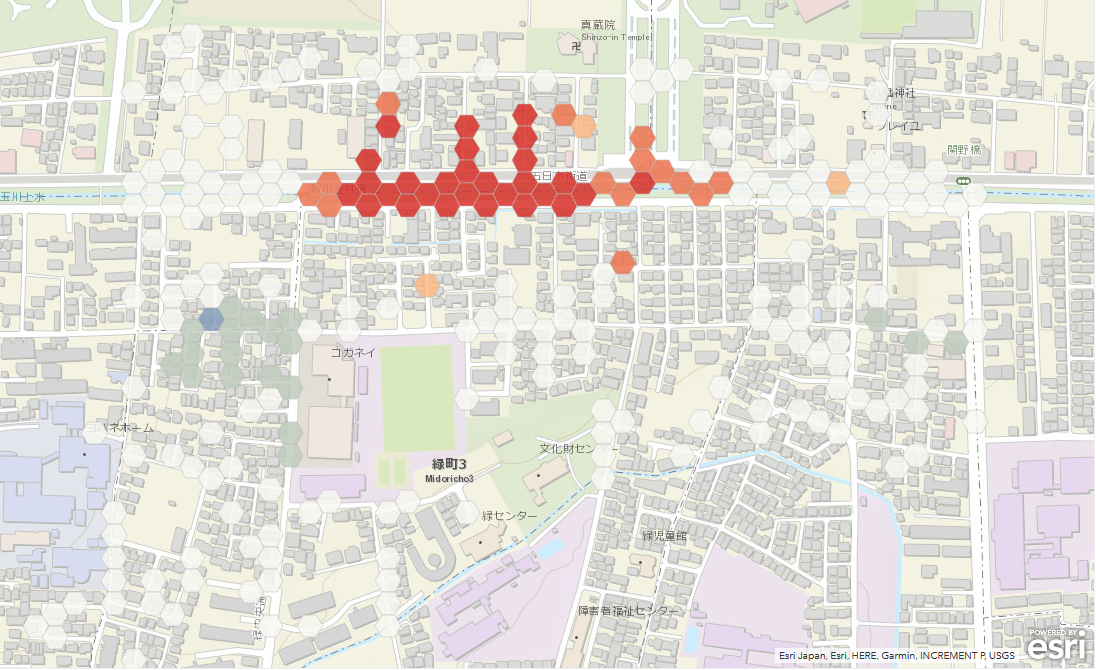